# Model Building and Evaluation

In [1]:
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt  # Matlab-style plotting
# Make sure plot shows immediately
%matplotlib inline 
import seaborn as sns # Library for plotting
color = sns.color_palette()
sns.set_style('darkgrid')

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import xgboost as xg 
from sklearn.metrics import mean_squared_error

In [2]:
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log(y_true + 1) - np.log(y_pred + 1),2)))

# Strategy A

In [14]:
X_a_train = pd.read_csv("./processed/strategy-a/train/X_train.csv", index_col=["MemberID"])
y_a_train = pd.read_csv("./processed/strategy-a/train/y_train.csv", index_col=["MemberID"])
X_a_test = pd.read_csv("./processed/strategy-a/test/X_test.csv", index_col=["MemberID"])
y_a_test = pd.read_csv("./processed/strategy-a/test/y_test.csv", index_col=["MemberID"])

## XGBoost

In [5]:
xgb_r = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123) 

In [22]:
xgb_r.fit(X_a_train, y_a_train) 

[00:40:48] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=4, num_parallel_tree=1,
             objective='reg:linear', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
select_col = pd.DataFrame(xgb_r.feature_importances_, columns=["Importance"], index=X_a_train.columns)

In [28]:
select_col = select_col[select_col["Importance"] > 0.01]

In [30]:
X_a_train[select_col.index]

,AgeAtFirstClaim,CharlsonIndexMax,ClaimCount,DSFSMin,DrugCountAvg,LabCountAvg,LengthOfStaySum,PayDelayMin,PlaceSvcCount_Independent Lab,PlaceSvcCount_Inpatient Hospital,...,PrimaryConditionGroupCount_RESPR4,PrimaryConditionGroupCount_ROAMI,ProcedureGroupCount_EM,ProcedureGroupCount_MED,ProcedureGroupCount_SCS,ProcedureGroupCount_SIS,Sex_NaN,SpecialtyCount_Emergency,SpecialtyCount_Internal,SpecialtyCount_Laboratory
MemberID,,,,,,,,,,,,,,,,,,,,,
210,0.418605,0.000000,0.166667,0.111111,0.238095,0.200000,0.002375,0.135802,0.046512,0.0,...,0.000000,0.000000,0.025641,0.117647,0.047619,0.0,1.0,0.074074,0.102564,0.046512
3197,0.069767,0.000000,0.095238,0.111111,0.178571,0.000000,0.000000,0.222222,0.000000,0.0,...,0.102564,0.000000,0.102564,0.000000,0.000000,0.0,0.0,0.074074,0.000000,0.000000
3889,0.000000,0.333333,0.285714,0.111111,0.428571,1.000000,0.003563,0.203704,0.093023,0.0,...,0.000000,0.000000,0.128205,0.000000,0.047619,0.0,0.0,0.148148,0.102564,0.093023
4187,0.651163,0.000000,0.071429,0.111111,0.871429,0.000000,0.000000,0.179012,0.000000,0.0,...,0.000000,0.000000,0.076923,0.000000,0.000000,0.0,0.0,0.000000,0.051282,0.000000
9063,0.767442,0.000000,0.071429,0.111111,0.142857,0.000000,0.000000,0.240741,0.000000,0.0,...,0.000000,0.000000,0.051282,0.000000,0.000000,0.0,0.0,0.000000,0.076923,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995554,0.534884,0.000000,0.809524,0.111111,0.285714,0.366667,0.000000,0.141975,0.162791,0.0,...,0.000000,0.000000,0.102564,0.705882,0.190476,0.0,0.0,0.000000,0.666667,0.162791
99996214,0.534884,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.117284,0.000000,0.0,...,0.000000,0.000000,0.025641,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
99997485,0.186047,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.802469,0.000000,0.0,...,0.000000,0.000000,0.025641,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [31]:
xgb_r.fit(X_a_train[select_col.index], y_a_train)

[00:46:25] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=4, num_parallel_tree=1,
             objective='reg:linear', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

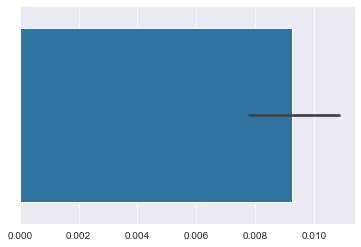

In [8]:
sns.barplot(xgb_r.feature_importances_)

In [33]:
# Predict the model 
pred = xgb_r.predict(X_a_test[select_col.index]) 

In [35]:
# RMSLE Computation 
print("RMSLE : %f" %(rmsle(y_a_test, pred))) 

RMSLE : 0.502390


## Support Vector Regression

In [15]:
regressor = SVR(kernel='rbf', C=1.0)

In [24]:
regressor.fit(X_a_train.to_numpy(),y_a_train.to_numpy())

SVR()

In [25]:
y_pred = regressor.predict(X_a_test.to_numpy())

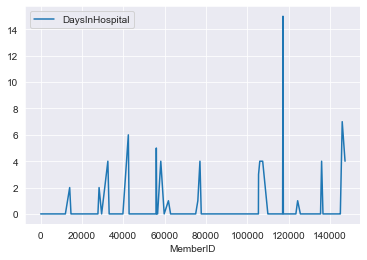

In [25]:
sns.lineplot(data=y_a_test[:100])

In [26]:
rmsle(y_a_test.to_numpy().T, y_pred.T)

0.46945039082707135

# Strategy B

In [5]:
X_b_train = pd.read_csv("./processed/strategy-b/train/X_train.csv", index_col=["MemberID"])
y_b_train = pd.read_csv("./processed/strategy-b/train/y_train.csv", index_col=["MemberID"])
X_b_test = pd.read_csv("./processed/strategy-b/test/X_test.csv", index_col=["MemberID"])
y_b_test = pd.read_csv("./processed/strategy-b/test/y_test.csv", index_col=["MemberID"])

## XGBoost

In [4]:
xgb_b = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123) 

In [5]:
xgb_b.fit(X_b_train, y_b_train) 

[08:43:37] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=4, num_parallel_tree=1,
             objective='reg:linear', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [6]:
# Predict the model 
b_pred = xgb_b.predict(X_b_test) 

In [8]:
b_pred.shape

(14287,)

In [12]:
rmsle(y_b_test.to_numpy().T, b_pred.T)

0.483611922398123

In [9]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = xg.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 4)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [11]:
hyperParameterTuning(X_b_train[:100], y_b_train[:100])

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  9.0min finished


{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

## Support Vector Regression